# Stable diffusion XL with base + refiner

Using model stabilityai/stable-diffusion-xl-base-1.0 with base + refiner

## Install requirements

In [1]:
!python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%pip install -r requirements-torch-windows.txt --upgrade
%pip install -r requirements.txt --upgrade

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu117
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Init stable diffusion

- https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0
- https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_xl

In [3]:
from diffusers import DiffusionPipeline
import torch

def init_refined_diffusion_pipeline(model_id, refiner_id):
    base = DiffusionPipeline.from_pretrained(
        model_id, torch_dtype=torch.float16, variant="fp16", use_safetensors=True
    )
    _ = base.to("cuda")

    refiner = DiffusionPipeline.from_pretrained(
        refiner_id,
        text_encoder_2=base.text_encoder_2,
        vae=base.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
    )
    _ = refiner.to("cuda")
    return base, refiner

pipe_base, pipe_refiner = init_refined_diffusion_pipeline("stabilityai/stable-diffusion-xl-base-1.0","stabilityai/stable-diffusion-xl-refiner-1.0")

C:\Users\key\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


In [4]:
def generate(prompt, seed=42):
    # Define how many steps and what % of steps to be run on each experts (80/20) here
    n_steps = 40
    high_noise_frac = 0.8
    generator = torch.Generator("cuda").manual_seed(seed)
    # run both experts
    base_image = pipe_base(
        prompt=prompt,
        num_inference_steps=n_steps,
        denoising_end=high_noise_frac,
        output_type="latent",
        generator=generator
    ).images[0]
    refined_image = pipe_refiner(
        prompt=prompt,
        num_inference_steps=n_steps,
        denoising_start=high_noise_frac,
        image=base_image,
        generator=generator
    ).images[0]
    fname = f"images/{prompt.replace(' ','-')}.png"
    refined_image.save(fname)
    display(refined_image)
    return refined_image


# Run

100%|██████████| 8/8 [04:16<00:00, 32.08s/it]


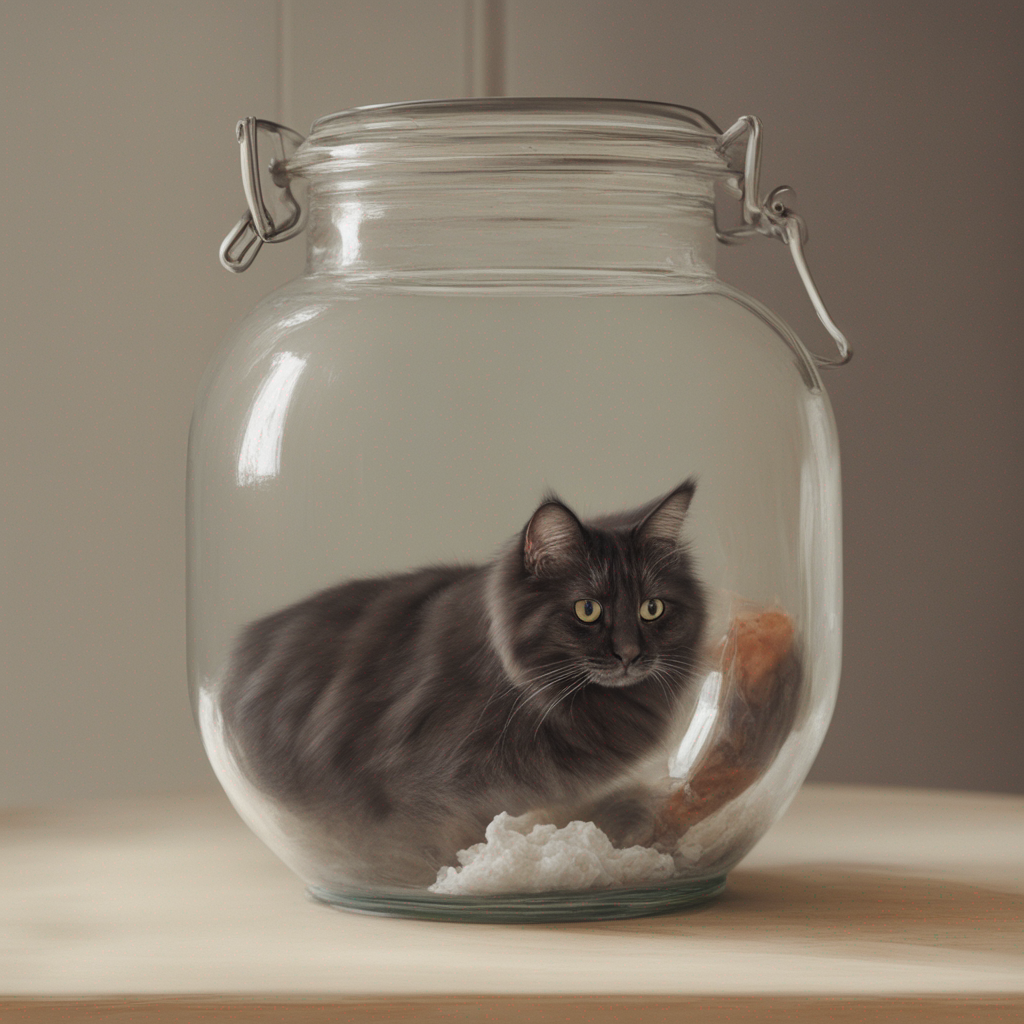

100%|██████████| 8/8 [03:27<00:00, 25.96s/it]


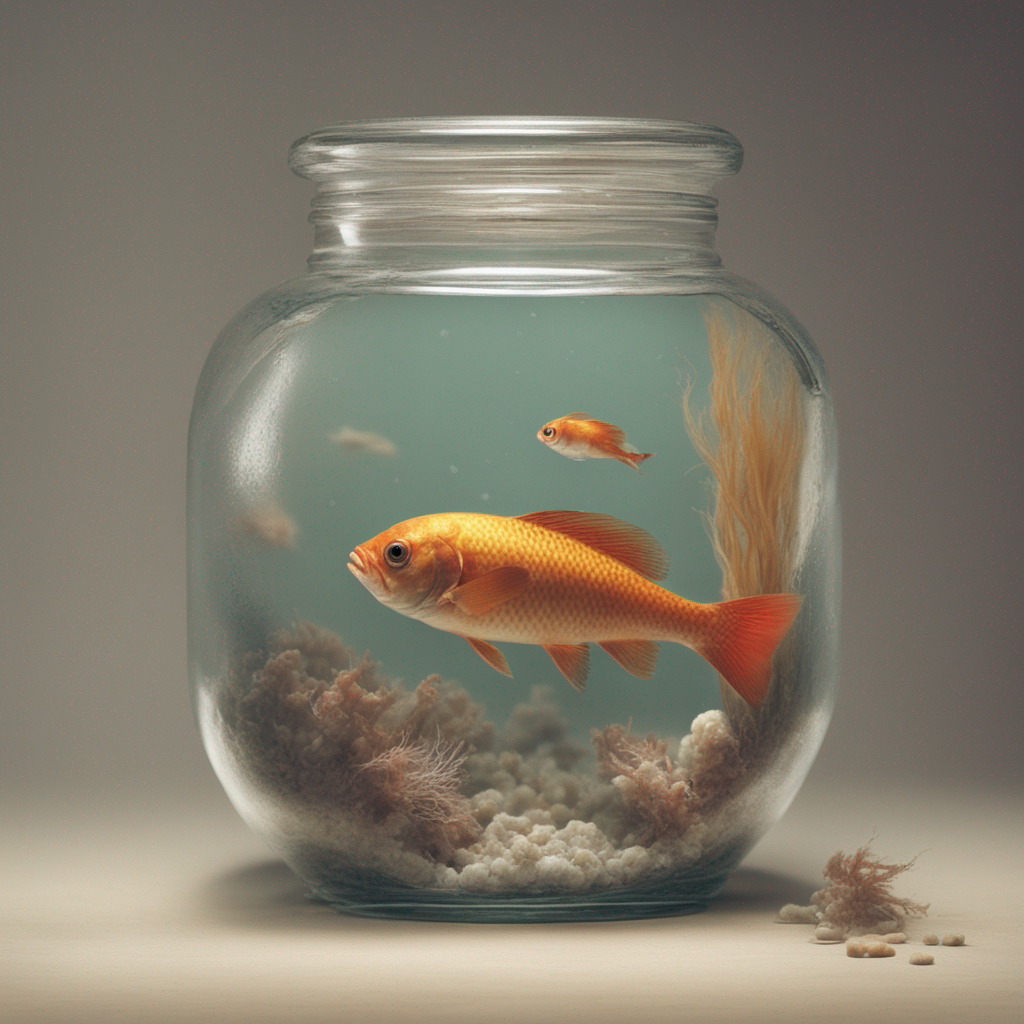

In [5]:
img = generate("un chat dans un bocal")
img = generate("un poisson dans un bocal")